# Verify


In [3]:
print('Hello Slicer')

Hello Slicer


# Setup


In [4]:
# import scipy.ndimage
pass

In [5]:
import numpy as np
import JupyterNotebooksLib as slicernb
import logging
import time
import sys
import pickle
import json
from collections import deque
from queue import PriorityQueue

from importlib import reload

reload(logging)

<module 'logging' from '/Applications/Slicer4.app/Contents/lib/Python/lib/python3.6/logging/__init__.py'>

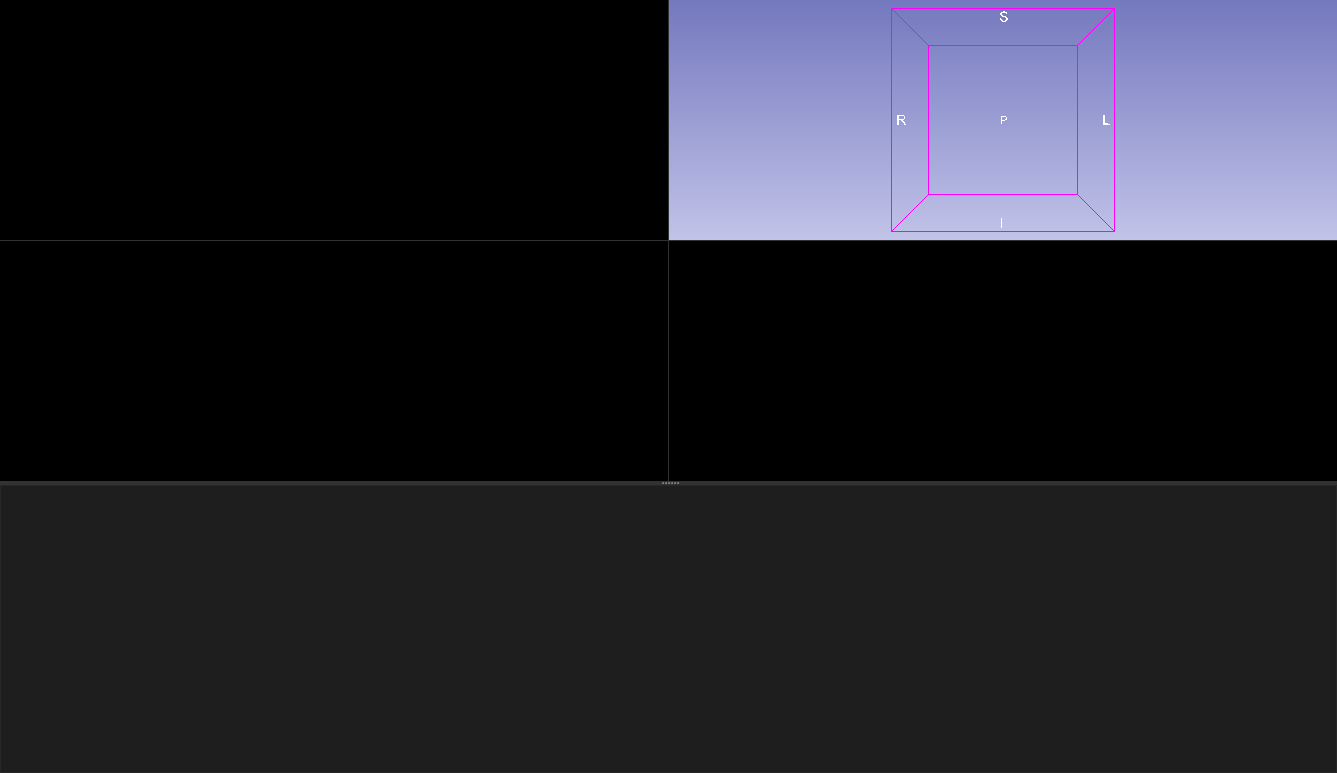

In [6]:
slicernb.ViewDisplay(center=False)

In [7]:
# create logger
logger = logging.getLogger('scratch_logger')
logger.setLevel(logging.DEBUG)

logstream_ch = logging.StreamHandler()
logstream_ch.setLevel(logging.INFO)

logfile_ch = logging.FileHandler('bfs.log')
logfile_ch.setLevel(logging.DEBUG)

logger.addHandler(logstream_ch)
logger.addHandler(logfile_ch)

In [8]:
loadScene('data/slicer_gs_clean_update1/2023-10-26-Scene.mrml')

In [9]:
# # create debug console
# console = qt.QTabWidget()
# console_tab1 = qt.QWidget()
# console_tab1_layout = qt.QHBoxLayout(console_tab1)
# btnA = qt.QPushButton('Calculate')
# btnB = qt.QPushButton('B')
# console_tab1_layout.addWidget(btnA)
# console_tab1_layout.addWidget(btnB)

# console.addTab(console_tab1, 'tab1')

# console.show()

# btnA.disconnect('clicked()', calculate_backbone)
# btnA.connect('clicked()', calculate_backbone)

# # btnA.disconnect('clicked()', btnA_action)
# # btnA.connect('clicked()', btnA_action)

# # btnB.disconnect('clicked()', btnB_action)
# # btnB.connect('clicked()', btnB_action)

pass

In [10]:
# slicernb.ViewDisplay()
# slicernb.ViewLightboxDisplay(columns=5, rows=3, rangeShrink=[15,20])
pass

In [11]:
# # Clear scene
# slicer.mrmlScene.Clear(False)

# Load from local file
# volume = slicer.util.loadVolume('data/MRBrainTumor1.nrrd')


# # Lightbox view
# slicernb.ViewLightboxDisplay("Red", rangeShrink=[45,50])
pass

## Global


In [14]:
def vtk4x4matrix_to_numpy(matrix):
    """
    Copies the elements of a vtkMatrix4x4 into a numpy array.

    :param matrix: The matrix to be copied into an array.
    :type matrix: vtk.vtkMatrix4x4
    :rtype: numpy.ndarray
    """
    m = np.ones((4, 4))
    for i in range(4):
        for j in range(4):
            m[i, j] = matrix.GetElement(i, j)
    return m


VOLUME_NODE_NAME = '14: Body Soft Tissue'
OUT_A_NODE_NAME = 'out_a'
OUT_B_NODE_NAME = 'out_b'
OUT_C_NODE_NAME = 'out_c'
MYNULL = -2_147_483_648

volume_node = getNode(VOLUME_NODE_NAME)
volume_display = volume_node.GetDisplayNode()
volume_display.InterpolateOff()

outa_node = getNode(OUT_A_NODE_NAME)
outa_node.GetDisplayNode().InterpolateOff()

outb_node = getNode(OUT_B_NODE_NAME)
outb_node.GetDisplayNode().InterpolateOff()

outc_node = getNode(OUT_C_NODE_NAME)
outc_node.GetDisplayNode().InterpolateOff()

lad_node = getFirstNodeByName('LAD')
lcx_node = getFirstNodeByName('LCX')
rca_node = getFirstNodeByName('RCA')

v_arr = slicer.util.array(VOLUME_NODE_NAME)
print(v_arr.shape)
print(v_arr.min())
print(v_arr.max())
print(v_arr.dtype)

x = vtk.vtkMatrix4x4()
volume_node.GetIJKToRASMatrix(x)
ijk2ras_mat = vtk4x4matrix_to_numpy(x)

volume_node.GetRASToIJKMatrix(x)
ras2ijk_mat = vtk4x4matrix_to_numpy(x)

seg_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSegmentationNode')
seg_node.SetName('myseg')

# ras2ijk_mat @ np.array([326,192,160,1]).reshape(-1,1)

(275, 512, 512)
-3024
1960
int32


## Util


In [16]:
def get_fiducial_as_kji(fiducial_node, i):
    ras_homo = np.ones([4, 1])
    fiducial_node.GetNthFiducialPosition(i, ras_homo[:3, 0])
    return tuple(
        (np.round(ras2ijk_mat @ ras_homo).astype(np.uint16).T)[
            (0, 0, 0), (2, 1, 0)
        ].tolist()
    )


def get_fiducial_data(fiducial_node, i):
    ras_homo = np.ones([4, 1])
    fiducial_node.GetNthFiducialPosition(i, ras_homo[:3, 0])
    posk, posj, posi = (np.round(ras2ijk_mat @ ras_homo).astype(np.uint16).T)[
        (0, 0, 0), (2, 1, 0)
    ].tolist()
    r, a, s = ras_homo[:3, 0]
    lb = fiducial_node.GetNthControlPointLabel(i)
    return (lb, r, a, s, posi, posj, posk)


def ijk2kji(ijk):
    return (ijk[2], ijk[1], ijk[0])


def multi_add_fiducial(fid_node, nodes_ras_Nx3):
    for i in range(len(nodes_ras_Nx3)):
        fid_node.AddFiducialFromArray(nodes_ras_Nx3[i, :])


# def coord2z(i,j,k):
#     return i * (262144) + j * (512) + k
# def z2coord(z):
#     # a[i//(6*7),(i%(6*7)//7),i%(7)]
#     return z//(512*512), z%(262144)//512, z%512


def coord2z(i, j, k):
    return i * (727609) + j * (853) + k


def z2coord(z):
    # a[i//(6*7),(i%(6*7)//7),i%(7)]
    return z // (727609), z % (727609) // 853, z % 853

In [11]:
# create segmentation node to store result
# seg_node = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")

# seg_node.SetName("segmentation_result")
# labelmap_node = getNode('labelmap_template')
pass

In [12]:
# import MRMLCorePython
# labelmap_node = MRMLCorePython.vtkMRMLLabelMapVolumeNode()
pass

In [ ]:
# def create_result(in_arr):
#     # seg_arr = np.zeros(v_arr.shape)
#     # seg_arr[100:,:,:] = 1
#     seg_arr = in_arr.copy().astype('int16')
#     updateVolumeFromArray(labelmap_node, seg_arr)
#     slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(labelmap_node, seg_node)
pass

In [ ]:
# d_arr = v_arr.copy()
# r_arr = v_arr.copy()
# del r_arr
pass

# Data Analysis Export


In [ ]:
import pandas as pd

In [ ]:
lad_node

In [ ]:
pda_col_list = ['label', 'artery', 'R', 'A', 'S', 'k', 'j', 'i', 'hu']
pda_data_map = {e: [] for e in pda_col_list}
for artery_fid_node, artery_name in zip(
    [lad_node, lcx_node, rca_node], ['LAD', 'LCX', 'RCA']
):
    n = artery_fid_node.GetNumberOfControlPoints()
    for i in range(n):
        label, pos_r, pos_a, pos_s, pos_i, pos_j, pos_k = get_fiducial_data(
            artery_fid_node, i
        )
        # label = artery_fid_node.GetNthControlPointLabel(i)
        # print(label)
        hu = v_arr[pos_k, pos_j, pos_i]
        pda_data_map['label'].append(label)
        pda_data_map['artery'].append(artery_name)
        pda_data_map['R'].append(pos_r)
        pda_data_map['A'].append(pos_a)
        pda_data_map['S'].append(pos_s)
        pda_data_map['i'].append(pos_i)
        pda_data_map['j'].append(pos_j)
        pda_data_map['k'].append(pos_k)
        pda_data_map['hu'].append(hu)


df = pd.DataFrame(pda_data_map)
df.to_csv('data/pda/fiducial_markers_data.csv')
np.save('data/pda/volume_array.npy', v_arr)

In [ ]:
d_arr = v_arr.copy()
d_arr[d_arr > -200] = MYNULL
d_arr[d_arr < -1050] = MYNULL
d_arr[d_arr != MYNULL] = 500

updateVolumeFromArray(canvas_node, d_arr)

In [ ]:
# start_point = [0,0,0]
# getNode("LAD_2").GetNthFiducialPosition(0, start_point)
# # start_point = (start_point * np.array([-1, 1, -1])).astype("int32")
# start_point = (start_point * np.array([1, 1, 1])).astype("int32")
# i,j,k = start_point

# i,j,k = [162, 198, 313]

# d_arr = v_arr.copy()
# d_arr[:] = MYNULL
# d_arr[i-50:i+50,j-50:j+50,k-50:k+50] = 500
# updateVolumeFromArray(canvas_node, d_arr)


In [ ]:
# numpy data format
# i - z 0 is downmost
# j - y 0 is topmost
# k - x 0 is leftmost
pass

In [ ]:
pos_a = np.arange(5 * 6 * 7).reshape(5, 6, 7)
for pos_i in range(5 * 6 * 7):
    print(pos_a[pos_i // (6 * 7), (pos_i % (6 * 7) // 7), pos_i % (7)])

In [ ]:
# visualize
d_arr = v_arr.copy()
d_arr[:] = MYNULL
d_arr[85:186, 115:256, 240:401] = 2000

updateVolumeFromArray(canvas_node, d_arr)

In [ ]:
# gradient filter
d_arr = v_arr.copy()
grads = np.gradient(d_arr)

d_arr = np.sqrt(grads[0] ** 2 + grads[1] ** 2 + grads[2] ** 2)
# d_arr = d_arr/100
updateVolumeFromArray(canvas_node, d_arr)

print(np.min(d_arr))
print(np.max(d_arr))

# Flood Fill


In [ ]:
EXP_NAME = 'default EXP NAME'

# inclusive bound
bound = np.array([[85, 185], [115, 255], [240, 401]])


def is_valid_index(i, j, k):
    # bounding
    return i >= 85 and j >= 115 and k >= 240 and i < 186 and j < 256 and k < 401
    return i >= 0 and j >= 0 and k >= 0 and i < 275 and j < 512 and k < 512


# bfs

# LAD
seed = (162, 198, 313)
end_node = (152, 175, 345)

# LCX
seed = (160, 204, 306)
end_node = (151, 212, 303)

# RCA
seed = (93, 156, 282)
end_node = (122, 138, 274)

t_start = time.time()

queue = [seed]
visited = {seed}
mask_index = {seed}
# grid = np.array([])
visit_order = {seed: 0}


# offsets = []
# for i in [-1,0,1]:
#     for j in [-1,0,1]:
#         for k in [-1,0,1]:
#             if i != 0 or j != 0 or k != 0:
#                 offsets.append(np.array([i,j,k]))
kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 1:4, 1:4] = 1
kernel_mask[2, 2, 2] = 0

kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])
# offsets = []

r_arr = v_arr.copy()
it = 0

is_reach = False

while len(queue) and it < 2e6:
    it += 1
    v = queue.pop(0)

    vi, vj, vk = v
    vb = r_arr[vi, vj, vk]

    pos = np.array(v)

    # debug
    next_visit_order = visit_order[v] + 1

    for pos_i in range(kernel_idxs.shape[1]):
        w = tuple((kernel_idxs[:, pos_i] + pos).tolist())
        wi, wj, wk = w

        # logger.debug(w)
        if not is_valid_index(wi, wj, wk):
            # print(wi, wj, wk)
            continue
        if w in visited:
            continue

        wb = r_arr[wi, wj, wk]
        diff = abs(vb - wb)
        if (
            wb < -300 and wb > -1200 and (diff < 250 or wb < -400)
        ) or wb > 150:  # calcium
            visited.add(w)
            mask_index.add(w)
            queue.append(w)
            visit_order[w] = next_visit_order

            if w == end_node:
                is_reach = True
                break

    if is_reach:
        break


logger.info(f'experiment: {EXP_NAME} time: {time.time() - t_start}')
logger.info(f'is_reach: {is_reach}')
logger.info(f'masked:           {len(mask_index)}')
logger.info(f'last iteration:   {it}')

c_arr = v_arr.copy()
c_arr[:] = MYNULL
for pos_i, pos_j, pos_k in mask_index:
    c_arr[pos_i, pos_j, pos_k] = 500

updateVolumeFromArray(outa_node, c_arr)

c_arr = v_arr.copy()
c_arr[:] = MYNULL
for v, o in visit_order.items():
    pos_i, pos_j, pos_k = v
    c_arr[pos_i, pos_j, pos_k] = o * 100

updateVolumeFromArray(outb_node, c_arr)

In [ ]:
## check z translation function

# for v in range(1,275*512*512,7):
#     # i,j,k = z2coord(v)
#     # print(idx_arr_t[i,j,k])
#     if v != coord2z(*z2coord(v)):
#         print('broke')
#         break
# else:
# print('work')

In [ ]:
kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 1:4, 1:4] = 1
kernel_mask[2, 2, 2] = 0
kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

# bfs find path
# seed = (162, 198, 313)
# end_node = (152, 175, 345)
queue = deque()

dist_grid = np.zeros_like(v_arr, np.uint16)
dist_grid[:] = 1e9

pred_grid = np.zeros_like(v_arr, np.int32)
pred_grid[:] = -1
queue.append(seed)
visited = set()

it = 0

visited.add(seed)
is_reach = False
while queue and it < 2e6:
    it += 1
    u = queue.popleft()
    pos = np.array(u)
    # print('pop', u)
    for pos_i in range(kernel_idxs.shape[1]):
        v = tuple((kernel_idxs[:, pos_i] + pos).tolist())
        if v not in visited and v in mask_index:
            visited.add(v)
            # dist_grid[v] = dist_grid[v] + 1
            vi, vj, vk = v
            pred_grid[vi, vj, vk] = coord2z(*u)
            queue.append(v)

            if v == end_node:
                is_reach = True

                break
        # else:
        #     print('in visited')

    if is_reach:
        break

print(it)
print(is_reach)
pos_i, pos_j, pos_k = end_node
print(pred_grid[pos_i, pos_j, pos_k])
# np.save('./data/pred_grid.npy', pred_grid)

In [ ]:
# i,j,k = end_node
pred_grid = np.load('./data/pred_grid.npy')
crawl = end_node
pos_i, pos_j, pos_k = crawl
path = []
it = 0
while pred_grid[pos_i, pos_j, pos_k] != -1 and it < 512 + 275 + 512:
    it += 1
    parent = z2coord(pred_grid[pos_i, pos_j, pos_k])
    path.append(parent)
    crawl = parent
    pos_i, pos_j, pos_k = crawl
# print(path)

c_arr = v_arr.copy()
c_arr[:] = MYNULL
for order, (pos_i, pos_j, pos_k) in enumerate(path):
    # i,j,k = u
    c_arr[pos_i, pos_j, pos_k] = (order + 1) * 100
updateVolumeFromArray(outc_node, c_arr)

In [ ]:
np.sum(c_arr == 500)
it

In [ ]:
seed

# Shortest Path


i >= 85 and j >= 115 and k >= 240 and i < 186 and j < 256 and k < 401


In [18]:
weight_arr = v_arr.copy()
boundi, boundj, boundk = weight_arr.shape

kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 1:4, 1:4] = 1
kernel_mask[2, 2, 2] = 0
kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

# for i in range(kernel_idxs.shape[1]):
#     oi, oj, ok = kernel_idxs[:,i]
#     crystal_mask = np.zeros_like(cost_arr, dtype=np.bool)
#     crystal_mask[1:boundi-1, 1:boundj-1, 1:boundk-1] = v_arr[1+oi:boundi-1+oi, 1+oi:boundj-1+oi, 1+oi:boundk-1+oi] - v_arr[1:boundi-1, 1:boundj-1, 1:boundk-1] > 800 # check if near crystal
#     cost_arr[crystal_mask] = -1200
#     # print(np.sum(crystal_mask[85:186,115:256,240:401]))

# transform raw to cost
COST_OFFSET = -50

weight_arr[weight_arr > COST_OFFSET] = 2_000_000_000
weight_arr[weight_arr <= COST_OFFSET] += 4000
# cost_arr[:] = 100

print(np.min(weight_arr), np.max(weight_arr))

updateVolumeFromArray(outa_node, weight_arr)

976 2000000000


In [22]:
def kji_list2ras(kji_tuples):
    return kji2ras(np.array(kji_tuples).T)


def kji2ras(kji_3xN):
    return (
        ijk2ras_mat @ np.pad(kji_3xN[::-1, :], ((0, 1), (0, 0)), constant_values=1)
    )[:3, :]


# x2 = kji_list2ras(full_path[:2])
# np.linalg.norm(x2[:,0] - x2[:,1]) * weight_arr[0,0,0]

In [ ]:
u = (0, 0, 0)
u_pos = np.array(u)
for pos_i in range(kernel_idxs.shape[1]):
    v = tuple((kernel_idxs[:, pos_i] + u_pos).tolist())
    vi, vj, vk = v

    ras_vecx2 = kji_list2ras([u, v])
    dist_uv = np.linalg.norm(ras_vecx2[:, 0] - ras_vecx2[:, 1])
    print(dist_uv)

In [ ]:
kernel_idxs

In [ ]:
u = (0, 0, 0)
u_pos = np.array(u)
for pos_i in range(kernel_idxs.shape[1]):
    v = tuple((kernel_idxs[:, pos_i] + u_pos).tolist())
    vi, vj, vk = v

    _uvk, _uvj, _uvi = kernel_idxs[:, pos_i] + 1
    dist_uv = kernel_ras_distance[_uvk, _uvj, _uvi]
    # print(_uvk,_uvj,_uvi)
    print(dist_uv)

In [ ]:
node_name = 'LCX'
fid_node = getNodes(node_name)[node_name]
fid_node.GetNthControlPointLabel(4)

In [ ]:
volume_node.GetSpacing()

In [30]:
ijk_spacing = volume_node.GetSpacing()
kernel_ras_distance = np.zeros((3, 3, 3), dtype=np.float64)
for pos_k in range(-1, 2):
    for pos_j in range(-1, 2):
        for pos_i in range(-1, 2):
            kernel_ras_distance[pos_k + 1, pos_j + 1, pos_i + 1] = (
                (pos_i * ijk_spacing[0]) ** 2
                + (pos_j * ijk_spacing[1]) ** 2
                + (pos_k * ijk_spacing[2]) ** 2
            ) ** 0.5
            # print(((i*ijk_spacing[0])**2 + (j*ijk_spacing[1])**2 + (k*ijk_spacing[2])**2)**0.5)
# dijkstra main function


def dijkstra(seed, end_node, weight_grid):
    kernel_mask = np.zeros((5, 5, 5))
    kernel_mask[1:4, 1:4, 1:4] = 1
    kernel_mask[2, 2, 2] = 0
    kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

    # dist_grid = np.zeros_like(v_arr, np.float64)
    # dist_grid[:] = 2e9
    # dist_grid[seed] = 0

    dist_map = dict()
    dist_map[seed] = 0

    pred_map = dict()

    # pred_grid = np.full(v_arr.shape, -1, dtype=np.int32)

    pq = PriorityQueue()
    pq.put((0, seed))
    it = 0

    is_reach = False
    debug_dict = dict()

    while (not pq.empty()) and it < 5e6 and (not is_reach):
        it += 1

        u_dist, u = pq.get()
        ui, uj, uk = u
        u_pos = np.array(u)

        if u == end_node:
            is_reach = True
            break

        if u in dist_map and u_dist > dist_map[u]:
            continue

        for i in range(kernel_idxs.shape[1]):
            v = tuple((kernel_idxs[:, i] + u_pos).tolist())
            vi, vj, vk = v

            # ras_vecx2 = kji_list2ras([u,v])
            # dist_uv = np.linalg.norm(ras_vecx2[:,0] - ras_vecx2[:,1])

            _uvk, _uvj, _uvi = kernel_idxs[:, i] + 1
            dist_uv = kernel_ras_distance[_uvk, _uvj, _uvi]
            # dist_uv = 1
            curr_cost = dist_uv * weight_grid[vi, vj, vk]

            dist = u_dist + curr_cost

            if v not in dist_map or dist < dist_map[v]:
                dist_map[v] = dist
                pred_map[v] = u
                pq.put((dist, v))

            # if v == end_node:
            #     is_reach = True

    print(it)

    # debug_dict['distgrid'] = dist_grid

    if not is_reach:
        print('not reach')
        return [], debug_dict

    # get path inclusive [start --> end]
    crawl = end_node
    i, j, k = crawl
    path = [crawl]
    it = 0
    # while  pred_grid[i,j,k] != -1 and it < 512+275+512:
    while crawl in pred_map and it < 512 + 275 + 512:
        print(it)
        it += 1
        # parent = z2coord(pred_grid[i,j,k])
        parent = pred_map[crawl]
        path.append(parent)
        crawl = parent
        # i,j,k = crawl
    # path.append(crawl)
    # print(path)
    path.reverse()

    # return
    return path, debug_dict


t_start = time.time()
node_name = 'LAD'
fid_node = getNodes(node_name)[node_name]
num_fid = fid_node.GetNumberOfFiducials()

seed = get_fiducial_as_kji(fid_node, 0)
end_node = get_fiducial_as_kji(fid_node, 1)
print(seed)
print(end_node)

path, ddl = dijkstra(seed, end_node, weight_arr)
print(path)

print(time.time() - t_start)

(162, 198, 313)
(162, 196, 317)
161
0
1
2
3
[(162, 198, 313), (162, 198, 314), (162, 198, 315), (162, 197, 316), (162, 196, 317)]
0.08524513244628906


: 

In [ ]:
dist_grid = ddl['distgrid']

In [ ]:
np.sum(dist_grid != 2e9)

In [ ]:
updateVolumeFromArray(outb_node, ddl['distgrid'])

In [ ]:
def calculate_backbone():
    t_start = time.time()
    EXP_NAME = 'TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH'

    node_name = 'LAD'
    fid_node = getNodes(node_name)[node_name]
    num_fid = fid_node.GetNumberOfFiducials()

    control_points_label2kji_map = {
        fid_node.GetNthFiducialLabel(i): np.array(get_fiducial_as_kji(fid_node, i))
        for i in range(num_fid)
    }
    control_points_label2vis_map = {
        fid_node.GetNthFiducialLabel(i): fid_node.GetNthFiducialVisibility(i)
        for i in range(num_fid)
    }

    # filter non visible node
    for k, v in control_points_label2vis_map.items():
        if not v:
            control_points_label2kji_map.pop(k, None)

    # NN TSP sort
    first_node_label = 'LAD-1'
    last_node_label = 'LAD-9'

    # first_node_label = 'RCA-4'
    # last_node_label = 'RCA-12'

    unselected_pool = set(control_points_label2kji_map.keys())
    control_points_order = [first_node_label]
    unselected_pool.remove(first_node_label)
    while len(unselected_pool):
        min_dist = 999999
        min_label = None
        current_node = control_points_label2kji_map[control_points_order[-1]]
        for label in unselected_pool:
            neighbor_node = control_points_label2kji_map[label]
            diff = current_node - neighbor_node
            dist = np.dot(diff, diff)
            if dist < min_dist:
                min_dist = dist
                min_label = label
        unselected_pool.remove(min_label)
        control_points_order.append(min_label)

        if min_label == last_node_label:
            break

    print(control_points_order)
    control_points_kji = [
        tuple(control_points_label2kji_map[e].tolist()) for e in control_points_order
    ]

    # find shortest path

    sub_paths = []
    for i in range(len(control_points_kji) - 1):
        # seed = get_fiducial_as_kji(fid_node, i)
        # end_node = get_fiducial_as_kji(fid_node, i+1)
        seed = control_points_kji[i]
        end_node = control_points_kji[i + 1]
        sub_path, _ = dijkstra(seed, end_node, weight_arr)
        if sub_path is not None:
            sub_paths.append(sub_path)

    for sub_path in sub_paths:
        print(sub_path)

    full_path = []
    c_arr = v_arr.copy()
    c_arr[:] = MYNULL

    for e in sub_paths:
        for order, (i, j, k) in enumerate(e):
            # i,j,k = u
            c_arr[i, j, k] = (order + 1) * 100
        full_path += e[0:-1]
    full_path.append(sub_paths[-1][-1])

    # for order,(i,j,k) in enumerate():
    #         # i,j,k = u
    #         c_arr[i,j,k] = 500

    updateVolumeFromArray(outc_node, c_arr)

    ###### logging result
    logger.info(f'experiment: {EXP_NAME} time: {time.time() - t_start}')
    # logger.info(f'is_reach: {is_reach}')
    logger.info(f'len path:           {len(full_path)}')
    # logger.info(f'last iteration:   {it}')
    # logger.info(f'{mycount}')

    return control_points_order, control_points_kji, full_path, sub_paths


# control_points_order, control_points_kji, full_path = calculate_backbone()

In [ ]:
t_start = time.time()
EXP_NAME = 'TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH'

node_name = 'RCA'
fid_node = getNodes(node_name)[node_name]
num_fid = fid_node.GetNumberOfFiducials()

control_points_label2kji_map = {
    fid_node.GetNthFiducialLabel(i): np.array(get_fiducial_as_kji(fid_node, i))
    for i in range(num_fid)
}
control_points_label2vis_map = {
    fid_node.GetNthFiducialLabel(i): fid_node.GetNthFiducialVisibility(i)
    for i in range(num_fid)
}

# filter non visible node
for pos_k, v in control_points_label2vis_map.items():
    if not v:
        control_points_label2kji_map.pop(pos_k, None)

# NN TSP sort
# first_node_label = 'LAD-1'
# last_node_label = 'LAD-9'

first_node_label = 'RCA-4'
last_node_label = 'RCA-12'

# first_node_label = 'LCX-1'
# last_node_label = 'LCX-8'


unselected_pool = set(control_points_label2kji_map.keys())
control_points_order = [first_node_label]
unselected_pool.remove(first_node_label)
while len(unselected_pool):
    min_dist = 999999
    min_label = None
    current_node = control_points_label2kji_map[control_points_order[-1]]
    for label in unselected_pool:
        neighbor_node = control_points_label2kji_map[label]
        diff = current_node - neighbor_node
        dist = np.dot(diff, diff)
        if dist < min_dist:
            min_dist = dist
            min_label = label
    unselected_pool.remove(min_label)
    control_points_order.append(min_label)

    if min_label == last_node_label:
        break

print(control_points_order)
control_points_kji = [
    tuple(control_points_label2kji_map[e].tolist()) for e in control_points_order
]

# find shortest path

sub_paths = []
for pos_i in range(len(control_points_kji) - 1):
    # seed = get_fiducial_as_kji(fid_node, i)
    # end_node = get_fiducial_as_kji(fid_node, i+1)
    seed = control_points_kji[pos_i]
    end_node = control_points_kji[pos_i + 1]
    sub_path = dijkstra(seed, end_node, cost_arr)
    if sub_path is not None:
        sub_paths.append(sub_path)

full_path = []
c_arr = v_arr.copy()
c_arr[:] = MYNULL

for e in sub_paths:
    for order, (pos_i, pos_j, pos_k) in enumerate(e):
        # i,j,k = u
        c_arr[pos_i, pos_j, pos_k] = (order + 1) * 100
    full_path += e[0:-1]
full_path.append(sub_paths[-1][-1])

# for order,(i,j,k) in enumerate():
#         # i,j,k = u
#         c_arr[i,j,k] = 500

updateVolumeFromArray(outc_node, c_arr)

###### logging result
logger.info(f'experiment: {EXP_NAME} time: {time.time() - t_start}')
# logger.info(f'is_reach: {is_reach}')
logger.info(f'len path:           {len(full_path)}')
# logger.info(f'last iteration:   {it}')
# logger.info(f'{mycount}')

In [ ]:
print(len(full_path))
print(len(set(full_path)))

In [ ]:
# LAD
seed = (162, 198, 313)
end_node = (152, 175, 345)

# # LCX
# seed = (160, 204, 306)
# end_node = (151, 212, 303)

# # RCA
# seed = (93, 156, 282)
# end_node = (122, 138, 274)

kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 1:4, 1:4] = 1
kernel_mask[2, 2, 2] = 0
kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

# dijkstra
EXP_NAME = 'DIJKSTRA SHORTEST PATH'
t_start = time.time()

dist_grid = np.zeros_like(v_arr, np.uint32)
dist_grid[:] = 2e9

pred_grid = np.full(v_arr.shape, -1, dtype=np.int32)

pq = PriorityQueue()
pq.put((0, seed))
it = 0

is_reach = False

mycount = 0


while (not pq.empty()) and it < 1e6 and (not is_reach):
    it += 1

    u_dist, u = pq.get()
    ui, uj, uk = u
    u_pos = np.array(u)

    if u_dist > dist_grid[ui, uj, uk]:
        mycount += 1
        continue

    for pos_i in range(kernel_idxs.shape[1]):
        v = tuple((kernel_idxs[:, pos_i] + u_pos).tolist())
        vi, vj, vk = v

        dist = u_dist + cost_arr[vi, vj, vk]

        if dist < dist_grid[vi, vj, vk]:
            dist_grid[vi, vj, vk] = dist
            pred_grid[vi, vj, vk] = coord2z(*u)
            pq.put((dist, v))

        if v == end_node:
            is_reach = True
            break

logger.info(f'experiment: {EXP_NAME} time: {time.time() - t_start}')
logger.info(f'is_reach: {is_reach}')
logger.info(f'masked:           {np.sum(pred_grid != -1)}')
logger.info(f'last iteration:   {it}')
logger.info(f'{mycount}')

# print path
crawl = end_node
pos_i, pos_j, pos_k = crawl
path = []
it = 0
while pred_grid[pos_i, pos_j, pos_k] != -1 and it < 512 + 275 + 512:
    it += 1
    parent = z2coord(pred_grid[pos_i, pos_j, pos_k])
    path.append(parent)
    crawl = parent
    pos_i, pos_j, pos_k = crawl
print(path)

c_arr = v_arr.copy()
c_arr[:] = MYNULL
for order, (pos_i, pos_j, pos_k) in enumerate(path):
    # i,j,k = u
    c_arr[pos_i, pos_j, pos_k] = (order + 1) * 100
updateVolumeFromArray(outc_node, c_arr)

# Create Curve


In [24]:
def calculate_backbone2(first_node_label, last_node_label, node_name):
    t_start = time.time()
    EXP_NAME = 'TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH'

    fid_node = getNodes(node_name)[node_name]
    num_fid = fid_node.GetNumberOfFiducials()

    control_points_label2kji_map = {
        fid_node.GetNthFiducialLabel(i): np.array(get_fiducial_as_kji(fid_node, i))
        for i in range(num_fid)
    }
    control_points_label2vis_map = {
        fid_node.GetNthFiducialLabel(i): fid_node.GetNthFiducialVisibility(i)
        for i in range(num_fid)
    }

    # filter non visible node
    for k, v in control_points_label2vis_map.items():
        if not v:
            control_points_label2kji_map.pop(k, None)

    # NN TSP sort
    # first_node_label = 'LAD-1'
    # last_node_label = 'LAD-9'

    # first_node_label = 'RCA-4'
    # last_node_label = 'RCA-12'

    unselected_pool = set(control_points_label2kji_map.keys())
    control_points_order = [first_node_label]
    unselected_pool.remove(first_node_label)
    while len(unselected_pool):
        min_dist = 999999
        min_label = None
        current_node = control_points_label2kji_map[control_points_order[-1]]
        for label in unselected_pool:
            neighbor_node = control_points_label2kji_map[label]
            diff = current_node - neighbor_node
            dist = np.dot(diff, diff)
            if dist < min_dist:
                min_dist = dist
                min_label = label
        unselected_pool.remove(min_label)
        control_points_order.append(min_label)

        if min_label == last_node_label:
            break

    print(control_points_order)
    control_points_kji = [
        tuple(control_points_label2kji_map[e].tolist()) for e in control_points_order
    ]

    # find shortest path

    sub_paths = []
    for i in range(len(control_points_kji) - 1):
        # seed = get_fiducial_as_kji(fid_node, i)
        # end_node = get_fiducial_as_kji(fid_node, i+1)
        seed = control_points_kji[i]
        end_node = control_points_kji[i + 1]
        sub_path, _ = dijkstra(seed, end_node, weight_arr)
        if sub_path is not None:
            sub_paths.append(sub_path)

    for sub_path in sub_paths:
        print(sub_path)

    full_path = []

    for e in sub_paths:
        full_path += e[0:-1]
    full_path.append(sub_paths[-1][-1])

    # for order,(i,j,k) in enumerate():
    #         # i,j,k = u
    #         c_arr[i,j,k] = 500

    ###### logging result
    logger.info(f'experiment: {EXP_NAME} time: {time.time() - t_start}')
    # logger.info(f'is_reach: {is_reach}')
    logger.info(f'len path:           {len(full_path)}')
    # logger.info(f'last iteration:   {it}')
    # logger.info(f'{mycount}')

    return control_points_order, control_points_kji, full_path, sub_paths


# control_points_order, control_points_kji, full_path = calculate_backbone()

In [25]:
# def create_curve_all_point(points_kji, curve_name):
#     x = np.array(points_kji, np.float)
#     x = x.T
#     x = x[::-1,:]
#     x = np.concatenate( [x, np.ones((1, x.shape[1]))] ,axis=0)
#     x = ijk2ras_mat @ x
#     x = x[:3,:]

#     curve_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsCurveNode')
#     curve_node.SetName(curve_name)

#     for pos_j in range(x.shape[1]):
#         curve_node.AddControlPoint(vtk.vtkVector3d(*x[:,pos_j]))

#     return curve_node


def create_curve(points_kji, curve_name, spacing=0.4):
    x = np.array(points_kji, np.float)
    x = x.T
    x = x[::-1, :]
    x = np.concatenate([x, np.ones((1, x.shape[1]))], axis=0)
    x = ijk2ras_mat @ x
    x = x[:3, :]

    curve_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsCurveNode')
    curve_node.SetName(curve_name)

    # TODO optimize to vectorize accumulation
    CURVE_CTRL_SPACING = spacing  # may be mm
    count = 0
    last_add_dist = 0
    curr_dist = 0
    curve_node.AddControlPoint(vtk.vtkVector3d(*x[:, 0]))

    for pos_j in range(1, x.shape[1]):
        prev_ras = x[:, pos_j - 1]
        curr_ras = x[:, pos_j]
        curr_dist += np.linalg.norm(curr_ras - prev_ras)
        if curr_dist - last_add_dist >= CURVE_CTRL_SPACING:
            count += 1
            # print(curr_dist - last_add_dist)
            curve_node.AddControlPoint(vtk.vtkVector3d(*x[:, pos_j]))
            last_add_dist = curr_dist

    return curve_node


# curve_name = "LAD_CONTROLPOINTS_CURVE"
# curve = create_curve(control_points_kji, curve_name, 0)
# print(f'{curve_name} - length: {curve.GetCurveLengthWorld():.2f}')

In [26]:
# first_node_label = 'LAD-1'
# last_node_label = 'LAD-9'

# first_node_label = 'RCA-4'
# last_node_label = 'RCA-12'

# first_node_label = 'LCX-1'
# last_node_label = 'LCX-8'


curve_data = dict()

for first_node_label, last_node_label, node_name in zip(
    ('LAD-1', 'RCA-4', 'LCX-1'), ('LAD-9', 'RCA-12', 'LCX-8'), ('LAD', 'RCA', 'LCX')
):
    control_points_order, control_points_kji, full_path, sub_paths = (
        calculate_backbone2(first_node_label, last_node_label, node_name)
    )

    curve_name = f'{node_name}_CONTROLPOINTS_CURVE'
    curve = create_curve(control_points_kji, curve_name, 0)

    curve_data[curve_name] = (
        control_points_order,
        control_points_kji,
        full_path,
        sub_paths,
        curve,
    )

    # control_points_order, control_points_kji, full_path, sub_paths = calculate_backbone2(first_node_label, last_node_label, node_name)

    curve_name = f'{node_name}_FINE_CURVE'
    curve = create_curve(full_path, curve_name, 0.4)

    curve_data[curve_name] = (
        control_points_order,
        control_points_kji,
        full_path,
        sub_paths,
        curve,
    )
    # print(f'{curve_name} - length: {curve.GetCurveLengthWorld():.2f}')

# c_arr = v_arr.copy()
# c_arr[:] = MYNULL
# for e in sub_paths:
#     for order,(i,j,k) in enumerate(e):
#     # i,j,k = u
#     c_arr[i,j,k] = (order + 1) * 100

# updateVolumeFromArray(outc_node, c_arr)

['LAD-1', 'LAD-2', 'LAD-3', 'LAD-4', 'LAD-5', 'LAD-6', 'LAD-7', 'LAD-8', 'LAD-9']
1834
35936
1811
985
906
2399
1334
829
[(433, 522, 330), (433, 522, 329), (433, 522, 328), (433, 522, 327), (433, 523, 326), (433, 523, 325), (433, 524, 324), (433, 525, 323)]
[(433, 525, 323), (432, 525, 322), (432, 525, 321), (432, 525, 320), (432, 525, 319), (432, 525, 318), (432, 525, 317), (432, 525, 316), (432, 526, 315), (432, 527, 314), (431, 528, 313), (430, 529, 312), (429, 530, 311), (428, 531, 310), (427, 532, 309)]
[(427, 532, 309), (427, 532, 308), (427, 532, 307), (427, 532, 306), (426, 533, 305), (425, 534, 304), (425, 535, 303)]
[(425, 535, 303), (424, 536, 302), (423, 537, 301), (422, 538, 300), (422, 538, 299)]
[(422, 538, 299), (421, 539, 298), (420, 540, 297), (419, 541, 296), (419, 542, 296)]
[(419, 542, 296), (418, 543, 295), (417, 544, 294), (416, 545, 293), (415, 546, 292), (414, 547, 291), (414, 548, 290)]
[(414, 548, 290), (413, 549, 289), (412, 550, 288), (411, 551, 287), (411, 

experiment: TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH time: 34.72196102142334
len path:           55


['RCA-4', 'RCA-6', 'RCA-5', 'RCA-7', 'RCA-8', 'RCA-9', 'RCA-1', 'RCA-10', 'RCA-2', 'RCA-3', 'RCA-13', 'RCA-14', 'RCA-11', 'RCA-16', 'RCA-15', 'RCA-12']
124885
51
4537
14866
1606
39
889
3657
2150
5000000
not reach
1644
160
45
585
39
[(249, 592, 382), (249, 593, 383), (249, 594, 384), (249, 595, 385), (249, 596, 386), (249, 597, 387), (249, 598, 388), (249, 599, 389), (249, 600, 390), (249, 601, 391), (249, 602, 392), (249, 603, 392), (249, 604, 392), (249, 605, 392), (249, 606, 393), (249, 607, 394), (249, 608, 394), (249, 609, 395), (249, 610, 395), (249, 611, 395), (249, 612, 395), (249, 613, 395), (250, 614, 395), (251, 615, 395), (251, 616, 395)]
[(251, 616, 395), (250, 616, 395), (249, 616, 396)]
[(249, 616, 396), (250, 616, 396), (251, 617, 395), (252, 617, 395), (253, 618, 395), (254, 619, 395), (255, 620, 395), (256, 620, 395), (257, 621, 395)]
[(257, 621, 395), (258, 622, 396), (259, 623, 397), (260, 624, 397), (261, 625, 397), (262, 626, 397), (263, 627, 397), (264, 628, 397),

experiment: TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH time: 491.7574439048767
len path:           92


['LCX-1', 'LCX-2', 'LCX-3', 'LCX-4', 'LCX-5', 'LCX-6', 'LCX-8']
724
806
1358
629
303
161
[(427, 512, 341), (426, 512, 341), (425, 512, 341), (424, 511, 342), (423, 511, 342), (422, 511, 342)]
[(422, 511, 342), (421, 510, 343), (420, 510, 343), (419, 510, 343), (418, 510, 343), (417, 510, 344)]
[(417, 510, 344), (416, 509, 345), (415, 509, 345), (414, 509, 346), (413, 508, 347), (412, 508, 347), (411, 508, 347)]
[(411, 508, 347), (410, 507, 347), (409, 507, 347), (408, 507, 347), (407, 507, 347), (406, 506, 347)]
[(406, 506, 347), (405, 505, 347), (404, 504, 347), (403, 503, 346)]
[(403, 503, 346), (403, 502, 346), (402, 501, 347), (402, 500, 347)]


experiment: TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH time: 22.227992057800293
len path:           28


In [ ]:
print(
    f'only control point curve - length: {ctrlpts_curve_node.GetCurveLengthWorld():.3f} mm.'
)
print(f'fine curve - length: {allpts_curve_node.GetCurveLengthWorld():.3f} mm.')

In [ ]:
len(curve_data['RCA_FINE_CURVE'][2])

In [ ]:
np.save('data/pda/full_path.npy', np.array(full_path))

In [ ]:
# sanity check
count = 0
for pos_i, sub_path in enumerate(sub_paths):
    unique_node = len(set(sub_path))
    print(f'path {pos_i}: {len(sub_path)} -uniq-> {unique_node}')
    count += unique_node
print(f'unique node: {count}')

In [ ]:
print(len(full_path))
print(len(set(full_path)))

In [ ]:
print(len(sub_paths))
for pos_i, sub_path in enumerate(sub_paths):
    curve_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsCurveNode')
    curve_node.SetName(f'debug_curve_{pos_i}')
    x = np.array(sub_path, np.float)
    x = x.T
    x = x[::-1, :]
    x = np.concatenate([x, np.ones((1, x.shape[1]))], axis=0)
    x = ijk2ras_mat @ x
    x = x[:3, :]

    for pos_j in range(0, x.shape[1], 8):
        curve_node.AddControlPoint(vtk.vtkVector3d(*x[:, pos_j]))

In [ ]:
ctrlpts_curve_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsCurveNode')
ctrlpts_curve_node.SetName('control_points_curve')

allpts_curve_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsCurveNode')
allpts_curve_node.SetName('all_points_curve')

In [ ]:
ras2ijk_mat @ np.concatenate(
    [nodes_pos[pos_i], np.ones((nodes_pos[pos_i].shape[0], 1))], axis=1
).T

In [ ]:
# create curve
for e in control_points_kji:
    # ctrlpts_curve_node.GetNthControlPointPosition(i, position)
    ctrlpts_curve_node.AddControlPoint(vtk.vtkVector3d(*e))

# for e in full_path:
#     allpts_curve_node.AddControlPoint(vtk.vtkVector3d(*e))

In [ ]:
x = np.array(control_points_kji, np.float)
x = x.T
x = x[::-1, :]
x = np.concatenate([x, np.ones((1, x.shape[1]))], axis=0)
x = ijk2ras_mat @ x
x = x[:3, :]

for pos_j in range(x.shape[1]):
    ctrlpts_curve_node.AddControlPoint(vtk.vtkVector3d(*x[:, pos_j]))
# for i in range()

# x = np.array(ijk2kji(x))

In [ ]:
x = np.array(full_path, np.float)
x = x.T
x = x[::-1, :]
x = np.concatenate([x, np.ones((1, x.shape[1]))], axis=0)
x = ijk2ras_mat @ x
x = x[:3, :]


# TODO optimize to vectorize accumulation
CURVE_CTRL_SPACING = 0.4  # may be mm
count = 0
last_add_dist = 0
curr_dist = 0
allpts_curve_node.AddControlPoint(vtk.vtkVector3d(*x[:, 0]))

for pos_j in range(1, x.shape[1]):
    prev_ras = x[:, pos_j - 1]
    curr_ras = x[:, pos_j]
    curr_dist += np.linalg.norm(curr_ras - prev_ras)
    if curr_dist - last_add_dist >= CURVE_CTRL_SPACING:
        count += 1
        # print(curr_dist - last_add_dist)
        allpts_curve_node.AddControlPoint(vtk.vtkVector3d(*x[:, pos_j]))
        last_add_dist = curr_dist
print(count)
print(curr_dist)

In [ ]:
print(
    f'only control point curve - length: {ctrlpts_curve_node.GetCurveLengthWorld():.3f} mm.'
)
print(f'fine curve - length: {allpts_curve_node.GetCurveLengthWorld():.3f} mm.')

In [ ]:
node_name = 'LCX'
first_node_label = 'LCX-1'
last_node_label = 'LCX-8'
control_points_order, control_points_kji, full_path, sub_paths = calculate_backbone2(
    first_node_label, last_node_label, node_name
)

curve_name = f'{node_name}_FINE_CURVE'
curve = create_curve(full_path, curve_name, 0.4)
updateVolumeFromArray(outa_node, weight_arr)

# Flood Fill without caps


In [27]:
curve_node = curve_data['LAD_FINE_CURVE'][4]
_curve_points = curve_node.GetCurvePointsWorld()
curve_points = [
    _curve_points.GetPoint(i) for i in range(_curve_points.GetNumberOfPoints())
]
del _curve_points

curve_points_kji = (
    np.round(
        ras2ijk_mat
        @ np.concatenate(
            [np.array(curve_points), np.ones((len(curve_points), 1))], axis=1
        ).T
    )
    .astype(np.uint16)
    .T
)[:, (2, 1, 0)].tolist()
curve_points_kji = {tuple(e) for e in curve_points_kji}
len(curve_points_kji)

79

In [39]:
# v1
kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 2, 2] = 1
kernel_mask[2, 1:4, 2] = 1
kernel_mask[2, 2, 1:4] = 1
kernel_mask[2, 2, 2] = 0
kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

# dist_grid = np.zeros_like(v_arr, np.float64)
# dist_grid[:] = 2e9
# dist_grid[seed] = 0

visited = set()
artery = []

# pred_grid = np.full(v_arr.shape, -1, dtype=np.int32)

pq = PriorityQueue()
it = 0

for seed in curve_points_kji:
    pq.put((0, seed))

MAX_PQ_OFFSET = 5
# DIFF_MAX = 300
DIFF_MAX = 150  # upsampling


is_reach = False
debug_dict = dict()

while (not pq.empty()) and it < 1e5:
    it += 1

    u_dist, u = pq.get()
    uk, uj, ui = u
    u_pos = np.array(u)
    artery.append((u_dist, u))

    for i in range(kernel_idxs.shape[1]):
        v = tuple((kernel_idxs[:, i] + u_pos).tolist())
        vk, vj, vi = v

        # ras_vecx2 = kji_list2ras([u,v])
        # dist_uv = np.linalg.norm(ras_vecx2[:,0] - ras_vecx2[:,1])

        # _uvk, _uvj, _uvi = kernel_idxs[:,i] + 1
        # dist_uv = kernel_ras_distance[_uvk, _uvj, _uvi]
        # curr_cost = dist_uv * v_arr[vi,vj,vk]

        # dist = u_dist + curr_cost

        diff = abs(v_arr[uk, uj, ui] - v_arr[vk, vj, vi])
        # if dist < dist_grid[vi,vj,vk]:
        if v not in visited and u_dist < MAX_PQ_OFFSET and v_arr[vk, vj, vi] <= -100:
            # dist_grid[vi,vj,vk] = dist
            # pred_grid[vi,vj,vk] = coord2z(*u)
            dist = u_dist + 1
            pq.put((dist, v))

        visited.add(v)

        # if v == end_node:
        #     is_reach = True

print(len(artery))


# updateVolumeFromArray(outc_node, c_arr)

2555


In [52]:
print(artery)

[(0, (406, 556, 281)), (0, (406, 557, 280)), (0, (406, 558, 279)), (0, (406, 559, 278)), (0, (406, 560, 277)), (0, (407, 556, 281)), (0, (408, 555, 282)), (0, (409, 552, 285)), (0, (409, 553, 283)), (0, (409, 553, 284)), (0, (409, 553, 285)), (0, (409, 554, 283)), (0, (409, 555, 283)), (0, (410, 552, 285)), (0, (411, 551, 286)), (0, (411, 551, 287)), (0, (411, 551, 288)), (0, (411, 552, 285)), (0, (412, 549, 288)), (0, (412, 550, 288)), (0, (413, 549, 289)), (0, (414, 547, 290)), (0, (414, 547, 291)), (0, (414, 547, 292)), (0, (414, 548, 290)), (0, (414, 549, 290)), (0, (415, 546, 292)), (0, (416, 545, 292)), (0, (416, 545, 293)), (0, (417, 544, 294)), (0, (418, 543, 295)), (0, (419, 540, 296)), (0, (419, 541, 296)), (0, (419, 542, 296)), (0, (420, 540, 297)), (0, (420, 540, 298)), (0, (421, 539, 298)), (0, (422, 538, 298)), (0, (422, 538, 299)), (0, (422, 538, 300)), (0, (423, 537, 301)), (0, (424, 536, 302)), (0, (425, 533, 305)), (0, (425, 534, 304)), (0, (425, 535, 303)), (0, (425,

In [55]:
1 / (1 + np.exp((v_arr[406, 557, 280] + 150) / 35))

0.9979161010499313

In [58]:
c_arr = v_arr.copy().astype(np.float64)
c_arr[:] = 0
for u_dist, (k, j, i) in artery:
    # k,j,i = u
    c_arr[k, j, i] = 1 / (1 + np.exp((v_arr[k, j, i] + 150) / 35))

print(np.min(c_arr), np.max(c_arr))

0.0 0.9999991918937072


In [53]:
np.unique(c_arr)

array([0.        , 0.93444987])

In [ ]:
c_arr = v_arr.copy()
c_arr[:] = MYNULL
for u_dist, (k, j, i) in enumerate(curve_points_kji):
    # i,j,k = u
    c_arr[k, j, i] = (u_dist + 5) * 100

updateVolumeFromArray(outc_node, c_arr)

In [32]:
x = seg_node.GetSegmentation().AddEmptySegment('testetest')
print(type(x))

<class 'str'>


In [29]:
def create_segmentation_from_labelmap(seg_node, volume, segname):
    seg_id = seg_node.GetSegmentation().AddEmptySegment(segname)

    labelmap_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLLabelMapVolumeNode')
    labelmap_node.CreateDefaultDisplayNodes()

    updateVolumeFromArray(labelmap_node, volume)

    direction = np.zeros((3, 3))
    volume_node.GetIJKToRASDirections(direction)

    labelmap_node.SetOrigin(volume_node.GetOrigin())
    labelmap_node.SetSpacing(volume_node.GetSpacing())
    labelmap_node.SetIJKToRASDirections(direction)

    seg_id_vtk = vtk.vtkStringArray()
    seg_id_vtk.InsertNextValue(seg_id)
    slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(
        labelmap_node, seg_node, seg_id_vtk
    )

    slicer.mrmlScene.RemoveNode(labelmap_node)
    return seg_id

In [36]:
create_segmentation_from_labelmap(
    seg_node, (c_arr != MYNULL).astype(np.int8), 'originallowthresh'
)

'originallowthresh'

In [59]:
create_segmentation_from_labelmap(seg_node, c_arr, 'fractional4')
del c_arr

: 

In [ ]:
mask[1 : K - 1, 1 : J - 1, 1 : I - 1].shape

In [ ]:
# dilate

mask = np.zeros_like(c_arr, np.bool)
mask[c_arr != MYNULL] = 1
result = mask.copy()

kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 1:4, 1:4] = 1
kernel_mask[2, 2, 2] = 0
kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

K, J, I = mask.shape

for i in range(kernel_idxs.shape[1]):
    oi, oj, ok = kernel_idxs[:, i]
    result[1 + ok : K - 1 + ok, 1 + oj : J - 1 + oj, 1 + oi : I - 1 + oi] += mask[
        1 : K - 1, 1 : J - 1, 1 : I - 1
    ]
    # print(np.sum(crystal_mask[85:186,115:256,240:401]))


print(np.sum(result))

create_segmentation_from_labelmap(seg_node, result.astype(np.int8), 'dilate')

In [ ]:
np.array([1, 2, 3]).roll(1)

In [ ]:
# dilate

mask = np.zeros_like(c_arr, np.bool)
mask[c_arr != MYNULL] = 1
result = mask.copy().astype(np.float64)

kernel_mask = np.zeros((5, 5, 5))
kernel_mask[1:4, 1:4, 1:4] = 1
kernel_mask[2, 2, 2] = 0
kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

K, J, I = mask.shape

for i in range(kernel_idxs.shape[1]):
    ok, oj, oi = kernel_idxs[:, i]
    result[np.roll(mask, (ok, oj, oi), (0, 1, 2)) & ~mask] = 0.5
    # print(np.sum(crystal_mask[85:186,115:256,240:401]))


print(np.sum(result))

create_segmentation_from_labelmap(seg_node, result, 'dilate_fractional')

# Flood Fill with caps


In [ ]:
len(curve_data['LAD_FINE_CURVE'])

In [ ]:
curve_node = curve_data['LAD_FINE_CURVE'][4]
n = curve_node.GetNumberOfControlPoints()
normal = np.zeros((3,))
position = np.zeros((3,))
normals = []
for i in range(n):
    curve_node.GetCurveDirectionAtPointIndexWorld(i, normal)
    normals.append(normal)

In [ ]:
normal = np.zeros((3,))
position = np.zeros((3,))
index = np.zeros((1,))
curve_node.GetCurveDirectionAtPointIndexWorld(5, normal)
print(curve_node.GetCurvePointIndexAlongCurveWorld())
print(index)
# print(position, normal)

In [ ]:
curve_length = curve_node.GetCurveLengthWorld()
n_segment = 6
segment_length = curve_length / n_segment

_curve_points = curve_node.GetCurvePointsWorld()
curve_points = [
    _curve_points.GetPoint(i) for i in range(_curve_points.GetNumberOfPoints())
]
del _curve_points

cpi = curve_node.GetCurvePointIndexAlongCurveWorld(0, segment_length)
normal = np.zeros((3,))
curve_node.GetCurveDirectionAtPointIndexWorld(cpi, normal)
position = np.array(curve_points[cpi])

print(normal, position)

t_line_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsLineNode')
t_line_node.SetName('tangent')

t_line_node.AddControlPoint(vtk.vtkVector3d(*position))
# t_line_node.AddControlPoint(vtk.vtkVector3d(*(position + normal))

In [ ]:
x = vtk.vtkVector3d(*position)
display(x)

# Create Fid


In [ ]:
#
x = getNode('myFMarkups')

In [ ]:
# Create a fiducial node
fiducial_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode')
fiducial_node.SetName('MyFiducials')

In [ ]:
curve_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsCurveNode')
curve_node.SetName('MyCurve')

In [ ]:
n = curve.GetNumberOfControlPoints()
position = [0, 0, 0]
for pos_i in range(n):
    curve.GetNthControlPointPosition(pos_i, position)
    curve_node.AddControlPoint(vtk.vtkVector3d(*position))
    print(position)

In [ ]:
type(fiducial_node)

In [ ]:
type(x)

In [ ]:
fiducial_node.AddFiducialFromArray(np.array([40, 50, 60]))

In [ ]:
nodes_pos

In [ ]:
# #Combine multiple fid to one fid

# LAD_fid_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode')
# LAD_fid_node.SetName('LAD')
# multi_add_fiducial(LAD_fid_node, nodes_pos[0])

# LCX_fid_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode')
# LCX_fid_node.SetName('LCX')
# multi_add_fiducial(LCX_fid_node, nodes_pos[1])

# RCA_fid_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode')
# RCA_fid_node.SetName('RCA')
# multi_add_fiducial(RCA_fid_node, nodes_pos[2])

In [ ]:
# # import slicer
# # from slicer.util import VTKObservationMixin

# class AnimationController(VTKObservationMixin):
#     def __init__(self, parent=None):
#         VTKObservationMixin.__init__(self)
#         self.parent = parent
#         self.slider = None
#         self.animation_logic = slicer.modules.animatedslices.logic()

#     def create_ui(self):
#         # Create slider
#         self.slider = slicer.qMRMLSliderWidget()
#         self.slider.minimum = 0
#         self.slider.maximum = 100
#         self.slider.value = 0
#         self.slider.setDecimals(0)
#         self.slider.singleStep = 1
#         self.slider.setToolTip("Animate slices")
#         self.parent.layout().addWidget(self.slider)

#         # Connect slider value change to animation logic
#         self.addObserver(self.slider, slicer.qMRMLSliderWidget.ValueChangedEvent, self.on_slider_value_changed)

#     def on_slider_value_changed(self, value):
#         # Update animation frame
#         frame = int(value)
#         self.animation_logic.setCurrentFrame(frame)

# # Instantiate the AnimationController
# controller = AnimationController(slicer.util.mainWindow())

# # Create the UI
# controller.create_ui()

# # Display the main window
# slicer.util.mainWindow().show()
pass

# Module Development


In [ ]:
module_names = moduleNames()
print('\n'.join(module_names[:10]))
print('number of module name:', len(module_names))
print('\n'.join(module_names), file=open('module_names.txt', 'w'))

In [ ]:
mod_ExtractCenterline = getModuleWidget('ExtractCenterline')
mod_ExtractCenterline.__dict__

In [ ]:
mod_logic_ExtractCenterline = getModuleLogic('ExtractCenterline')
mod_logic_ExtractCenterline.__dict__

In [ ]:
mod_CrossSectionAnalysis = getModuleWidget('CrossSectionAnalysis')
mod_CrossSectionAnalysis.__dict__

In [ ]:
print(len(full_path))
print(len(set(full_path)))

In [ ]:
nodeName = 'MyNewVolume'
imageSize = [512, 512, 512]
voxelType = vtk.VTK_
imageOrigin = [0.0, 0.0, 0.0]
imageSpacing = [1.0, 1.0, 1.0]
imageDirections = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
fillVoxelValue = 0

In [ ]:
(c_arr != MYNULL).dtype

In [ ]:
seg_id = 'test'
seg_node.GetSegmentation().AddEmptySegment(seg_id)

labelmap_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLLabelMapVolumeNode')
labelmap_node.CreateDefaultDisplayNodes()

updateVolumeFromArray(labelmap_node, (c_arr != MYNULL).astype(np.int8))

direction = np.zeros((3, 3))
volume_node.GetIJKToRASDirections(direction)

labelmap_node.SetOrigin(volume_node.GetOrigin())
labelmap_node.SetSpacing(volume_node.GetSpacing())
labelmap_node.SetIJKToRASDirections(direction)

seg_id_vtk = vtk.vtkStringArray()
seg_id_vtk.InsertNextValue(seg_id)
slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(
    labelmap_node, seg_node, seg_id_vtk
)

slicer.mrmlScene.RemoveNode(labelmap_node)

In [ ]:
# fillhole_arr = slicer.util.array('fillhole')
grindpeak_arr = slicer.util.array('grindpeak')

# updateVolumeFromArray(outa_node, fillhole_arr - v_arr)
updateVolumeFromArray(outb_node, v_arr - grindpeak_arr)  # look promisin

In [ ]:
x = v_arr - grindpeak_arr
print(x.min())
print(x.max())
np.save('data/grindpeak_caldet.npy', x)

In [ ]:
c_arr = v_arr.copy()
print(np.min(c_arr), np.max(c_arr))

In [ ]:
# create debug console
console = qt.QTabWidget()
console_tab1 = qt.QWidget()
console_tab1_layout = qt.QVBoxLayout(console_tab1)

console_tab1_row1 = qt.QWidget()
console_tab1_row1_layout = qt.QHBoxLayout(console_tab1_row1)
# comboA = qt.QComboBox()
comboB = slicer.qMRMLNodeComboBox()
comboB.nodeTypes = ['vtkMRMLMarkupsFiducialNode']
comboB.addEnabled = False
comboB.removeEnabled = False
comboB.noneEnabled = False
comboB.showHidden = False
comboB.showChildNodeTypes = False
comboB.setMRMLScene(slicer.mrmlScene)
btnA = qt.QPushButton('Calculate artery model')
# console_tab1_row1_layout.addWidget(comboA)
console_tab1_row1_layout.addWidget(comboB)
console_tab1_row1_layout.addWidget(btnA)

console_tab1_row2 = qt.QWidget()
console_tab1_row2_layout = qt.QHBoxLayout(console_tab1_row2)

btnB = qt.QPushButton('Calculate stenosis')
comboTable = slicer.qMRMLNodeComboBox()
comboTable.nodeTypes = ['vtkMRMLTableNode']
comboTable.addEnabled = False
comboTable.removeEnabled = False
comboTable.noneEnabled = False
comboTable.showHidden = False
comboTable.showChildNodeTypes = False
comboTable.setMRMLScene(slicer.mrmlScene)
console_tab1_row2_layout.addWidget(comboTable)
console_tab1_row2_layout.addWidget(btnB)

console.addTab(console_tab1, 'stenosis calculator')
console_tab1_layout.addWidget(console_tab1_row1)
console_tab1_layout.addWidget(console_tab1_row2)

console.show()

# btnA.disconnect('clicked()', calculate_backbone)
# btnA.connect('clicked()', calculate_backbone)


def btnA_action():
    calculate_stenosis()


def btnB_action():
    calculate_stenosis2()


btnA.disconnect('clicked()', btnA_action)
btnA.connect('clicked()', btnA_action)


btnB.disconnect('clicked()', btnB_action)
btnB.connect('clicked()', btnB_action)

pass

['LADtest-1', 'LADtest-2']
545406
[(160, 202, 307), (160, 202, 308), (160, 202, 309), (160, 201, 310), (160, 201, 311), (160, 201, 312), (160, 201, 313), (160, 201, 314), (160, 201, 315), (160, 201, 316), (160, 200, 317), (160, 200, 318), (160, 199, 319), (160, 198, 320), (160, 198, 321), (160, 197, 322), (160, 197, 323), (160, 196, 324), (160, 195, 325), (160, 194, 326), (160, 193, 327), (160, 192, 328), (159, 191, 329), (159, 190, 330), (158, 189, 331), (158, 188, 332), (157, 187, 333), (157, 186, 334), (156, 185, 335), (156, 184, 336), (155, 183, 337), (155, 182, 338), (154, 181, 339), (154, 180, 340), (153, 179, 341), (153, 178, 342), (152, 177, 343), (152, 176, 344), (152, 175, 345)]


experiment: TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH time: 45.34301400184631
len path:           39


Report Time
create_guide_line_curve, 45.457 s
create_segmentation, 1.074 s
['LADtest-1', 'LADtest-2']
545406
[(160, 202, 307), (160, 202, 308), (160, 202, 309), (160, 201, 310), (160, 201, 311), (160, 201, 312), (160, 201, 313), (160, 201, 314), (160, 201, 315), (160, 201, 316), (160, 200, 317), (160, 200, 318), (160, 199, 319), (160, 198, 320), (160, 198, 321), (160, 197, 322), (160, 197, 323), (160, 196, 324), (160, 195, 325), (160, 194, 326), (160, 193, 327), (160, 192, 328), (159, 191, 329), (159, 190, 330), (158, 189, 331), (158, 188, 332), (157, 187, 333), (157, 186, 334), (156, 185, 335), (156, 184, 336), (155, 183, 337), (155, 182, 338), (154, 181, 339), (154, 180, 340), (153, 179, 341), (153, 178, 342), (152, 177, 343), (152, 176, 344), (152, 175, 345)]


experiment: TSP + MULTI SUBPATH + DIJKSTRA SHORTEST PATH time: 45.669018268585205
len path:           39


Report Time
create_guide_line_curve, 45.850 s
create_segmentation, 1.146 s
min, max, stenosis
3.76309702330456, 39.67350614987364, 90.515%
min, max, stenosis
3.76309702330456, 39.67350614987364, 90.515%


Traceback (most recent call last):
  File "/Applications/Slicer4.app/Contents/Extensions-29738/SlicerVMTK/lib/Slicer-4.11/qt-scripted-modules/CrossSectionAnalysis.py", line 539, in setCurrentPointIndex
    self.logic.updateSliceView(pointIndex)
  File "/Applications/Slicer4.app/Contents/Extensions-29738/SlicerVMTK/lib/Slicer-4.11/qt-scripted-modules/CrossSectionAnalysis.py", line 993, in updateSliceView
    curvePointToWorld = self.getCurvePointToWorldTransformAtPointIndex(pointIndex)
  File "/Applications/Slicer4.app/Contents/Extensions-29738/SlicerVMTK/lib/Slicer-4.11/qt-scripted-modules/CrossSectionAnalysis.py", line 1071, in getCurvePointToWorldTransformAtPointIndex
    curveCoordinateSystemGenerator = slicer.vtkParallelTransportFrame()
AttributeError: module 'slicer' has no attribute 'vtkParallelTransportFrame'
Traceback (most recent call last):
  File "/Applications/Slicer4.app/Contents/Extensions-29738/SlicerVMTK/lib/Slicer-4.11/qt-scripted-modules/CrossSectionAnalysis.py", line

: 

In [19]:
def calculate_stenosis2():
    table_node = comboTable.currentNode()
    cross_sec_area = arrayFromTableColumn(table_node, 'Cross-section area')
    min_area = np.min(cross_sec_area)
    max_area = np.max(cross_sec_area)
    stenosis = 1 - (min_area / max_area)
    print(f'min, max, stenosis')
    print(f'{min_area}, {max_area}, {stenosis*100:.3f}%')

In [20]:
def calculate_stenosis():
    # all operation
    """
    {
        (index, name) : tz
    }
    """
    timestamp_map = dict()

    fid_node = comboB.currentNode()
    num_fid = fid_node.GetNumberOfFiducials()
    first_node_label = fid_node.GetNthFiducialLabel(0)
    last_node_label = fid_node.GetNthFiducialLabel(num_fid - 1)
    node_name = fid_node.GetName()

    ########## Create Guide Line curve ##########
    timestamp_map[(0, 'create_guide_line_curve')] = [time.time()]
    curve_data = dict()

    control_points_order, control_points_kji, full_path, sub_paths = (
        calculate_backbone2(first_node_label, last_node_label, node_name)
    )
    curve_name = f'{node_name}_FINE_CURVE'
    curve = create_curve(full_path, curve_name, 0.4)
    curve_data[curve_name] = (
        control_points_order,
        control_points_kji,
        full_path,
        sub_paths,
        curve,
    )
    timestamp_map[(0, 'create_guide_line_curve')].append(time.time())
    ########## Create segmentation ##########
    timestamp_map[(1, 'create_segmentation')] = [time.time()]
    # calculate segmentation
    curve_node = curve_data[curve_name][4]
    _curve_points = curve_node.GetCurvePointsWorld()
    curve_points = [
        _curve_points.GetPoint(i) for i in range(_curve_points.GetNumberOfPoints())
    ]
    del _curve_points

    curve_points_kji = (
        np.round(
            ras2ijk_mat
            @ np.concatenate(
                [np.array(curve_points), np.ones((len(curve_points), 1))], axis=1
            ).T
        )
        .astype(np.uint16)
        .T
    )[:, (2, 1, 0)].tolist()
    curve_points_kji = {tuple(e) for e in curve_points_kji}

    kernel_mask = np.zeros((5, 5, 5))
    kernel_mask[1:4, 2, 2] = 1
    kernel_mask[2, 1:4, 2] = 1
    kernel_mask[2, 2, 1:4] = 1
    kernel_mask[2, 2, 2] = 0
    kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

    visited = set()
    artery = []

    pq = PriorityQueue()
    it = 0

    for seed in curve_points_kji:
        pq.put((0, seed))

    MAX_PQ_OFFSET = 4
    DIFF_MAX = 300

    is_reach = False
    debug_dict = dict()

    while (not pq.empty()) and it < 1e4:
        it += 1

        u_dist, u = pq.get()
        uk, uj, ui = u
        u_pos = np.array(u)
        artery.append((u_dist, u))

        for i in range(kernel_idxs.shape[1]):
            v = tuple((kernel_idxs[:, i] + u_pos).tolist())
            vk, vj, vi = v

            diff = abs(v_arr[uk, uj, ui] - v_arr[vk, vj, vi])
            if (
                v not in visited
                and u_dist < MAX_PQ_OFFSET
                and v_arr[vk, vj, vi] <= -300
            ):
                dist = u_dist + 1
                pq.put((dist, v))

            visited.add(v)

    c_arr = v_arr.copy()
    c_arr[:] = MYNULL
    for u_dist, (k, j, i) in artery:
        # i,j,k = u
        c_arr[k, j, i] = (u_dist + 5) * 100

    # dilate

    mask = np.zeros_like(c_arr, np.bool)
    mask[c_arr != MYNULL] = 1
    result = mask.copy()

    kernel_mask = np.zeros((5, 5, 5))
    kernel_mask[1:4, 1:4, 1:4] = 1
    kernel_mask[2, 2, 2] = 0
    kernel_idxs = np.vstack(np.where(kernel_mask == 1)) - np.array([[2], [2], [2]])

    K, J, I = mask.shape

    for i in range(kernel_idxs.shape[1]):
        oi, oj, ok = kernel_idxs[:, i]
        result[1 + ok : K - 1 + ok, 1 + oj : J - 1 + oj, 1 + oi : I - 1 + oi] += mask[
            1 : K - 1, 1 : J - 1, 1 : I - 1
        ]
    # print(np.sum(crystal_mask[85:186,115:256,240:401]))

    # create segmentation
    seg_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSegmentationNode')
    seg_node.SetName(f'{node_name} segmentation')
    seg_id = create_segmentation_from_labelmap(
        seg_node, result.astype(np.int8), f'{node_name} dilate'
    )
    slicer.modules.segmentations.logic().ExportVisibleSegmentsToModels(seg_node, 0)

    # Create a fiducial node
    endpoints_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode')
    endpoints_node.SetName(f'{node_name} endpoints')
    # TODO simplify get only ras
    _, pos_r1, pos_a1, pos_s1, _, _, _ = get_fiducial_data(fid_node, 0)
    _, pos_r2, pos_a2, pos_s2, _, _, _ = get_fiducial_data(fid_node, num_fid - 1)
    multi_add_fiducial(
        endpoints_node, np.array([[pos_r1, pos_a1, pos_s1], [pos_r2, pos_a2, pos_s2]])
    )
    timestamp_map[(1, 'create_segmentation')].append(time.time())

    ##### report time
    print('Report Time')

    for order, session_name in sorted(timestamp_map.keys()):
        tstart, tstop = timestamp_map[(order, session_name)]
        duration = tstop - tstart
        print(f'{session_name}, {duration:.3f} s')

In [ ]:
# not sure how to control the smoothing
slicer.modules.segmentations.logic().ExportVisibleSegmentsToModels(seg_node, 0)

In [ ]:
table_node = getNode('Table')
type(table_node)